# Introduction of PyMC3 - Worked example: Bayesian linear regression

In this video we are going to examine how advertising budget affects product sales by introducing Bayesian
linear regression in PyMC3 package. PyMC3 is a Python package for probabilistic programming which allows you
to write down models using variable syntax to generate prior distribution and likelihood. Going further,
PyMC3 supports various Markov Chain Monte Carlo algorithms for model fitting, which is beautiful because it
can handle virtually any statistical model to obtain posterior distribution with a few lines of code.

There are a lot of jargons, but we are going to learn what those are. The main idea is that given the
initial understanding and the observed data in probability distribution, we can use Bayesian Linear
Regression in PyMC3 to determine the effect and quantify the uncertainty of TV advertisement on product
sales.

The model assumes that every parameters specifying the linear model are generated from a probability
distribution. Again, we are going to provide an initial estimate for each parameter and improve our estimate
as we gather more data.

In [1]:
# Let's bring in pandas as pd,
import pandas as pd
# numpy as np
import numpy as np
# and matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Now let's read the TV advertisement data into a pandas DataFrame
# Here index_col = 0 means we specify the data index using the value of the entire first column.
tv_data = pd.read_csv("Advertising.csv", index_col = 0)
# And let's look at the first few lines
tv_data.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


We can see that this observational data includes the advertising budgets (in thousands of dollars) of TV,
Radio, and Newspaper, and the information about the product sales in thousand units. For instance, we can
see in the first row that 22.1 thousands of sales were achieved after spending 230.1 thousands, 37.8
thousands, and 69.2 thousands of TV, Radio and Newspaper advertisement budgets respectively.

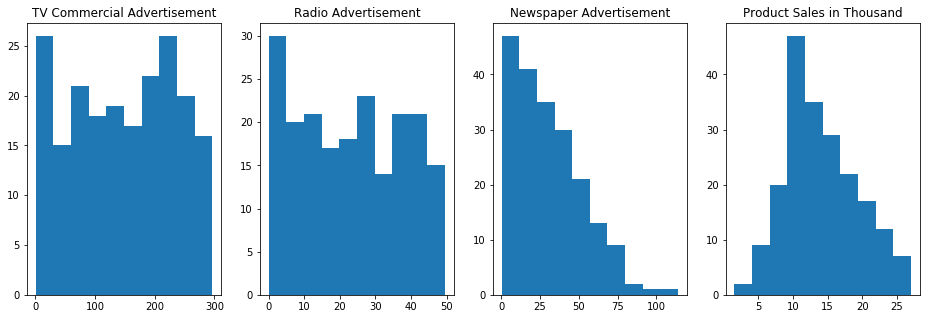

In [2]:
# We can create two objects fig and axes together to look at the 
# distribution of TV, radio, newspaper and sales columns 
# We use the matplotlib.pyplot.subplot function and pass through 1 and 4 to create 4 histograms
# Note that we turn off the share x-axis feature so each of the plots adapts to its own x range.
fig, axes = plt.subplots(1, 4, sharex = False, figsize = (16,5))

# The axes object is built in numpy ndarray, so specifying [0] and using .hist() function
# and .set_title() function can create a histogram and specify the title for TV commercial advertisement
axes[0].hist(tv_data.TV)
axes[0].set_title("TV Commercial Advertisement")

# For other columns we just specify the index 1, 2 and 3 and make a histogram using .hist()
# and set the titles accordingly.

axes[1].hist(tv_data.radio)
axes[1].set_title("Radio Advertisement")
axes[2].hist(tv_data.newspaper)
axes[2].set_title("Newspaper Advertisement")
axes[3].hist(tv_data.sales)
axes[3].set_title("Product Sales in Thousand")
plt.show()

Let's now set up the prior distribution to each parameter. 

A common way to understand the effect of TV advertisements on sales is to describe the relationship using a
model. We can specify the linear combination of TV advertisements and product sales by assigning the average
product sales in thousand without TV commercial advertisements as intercept $\alpha$ (**alpha**) and
assigning the increase of product sales in thousand by increasing TV advertising budget in thousand as
regression coefficient $\beta$ (**beta**). 

$$ Product\_Sales = \alpha + \beta \times (TV \_Ads) $$

In [3]:
# To simplify model specification, we create variables tv_ads and product_sales to store the TV advertisement 
# and product sales data as pandas series
tv_ads = tv_data['TV']
product_sales = tv_data['sales']

In [4]:
# With all these settings, let's import the pymc3 library as pm
import pymc3 as pm
# We are going to enter the process of model specification, in which the prior distributions of 
# parameters and the observed data are included to the Bayesian model.

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


## Model Specification

So, how to specify prior distribution? In PyMC3, the syntax of specifying the model is approximately the
same as the statistical notation. 

We can formulate our initial understanding based on the following:

- Without advertisement on TV, the sales of product is likely to be low. Let us choose the normal prior for intercept,
with mean 4 and standard deviation 2, which is the square root of 4. 

- Increasing TV commercial advertisement will slightly boost the product sales. Let us also choose the normal prior
for $\beta$ (**beta**). On top of that, let us hypothesize that one unit increase in TV advertising will
lead to 0.05 thousand unit increase in product sales, and the standard deviation is 0.05. 

- For the uncertainty of the effect of advertising budgets through television to product sales, literature suggests to assign a half-normal prior with 0 mean and a small number of variance.

- Since the histogram shows roughly a bell shape for the sales, we would like to predict the sales
(Y) as normally-distributed observations with expected value $\mu$ (**mu**) and variance $\sigma^2$ (**sigma
square**), where $\mu$ (**mu**) should follow the linear combination that predicts the sales.

$$\alpha \sim N(4,4)$$ $$\beta \sim N(0.05,0.05)$$ $$\sigma \sim |N(0,1)|$$  $$\mu = \alpha + \beta \times
(TV \_Ads)$$

### MCMC approach using PymC3

In [5]:
# We start with creating an instance model with an empty pm.Model function
model = pm.Model()

# Now let us specify the model. The with model statement wraps up every prior and likelihood
with model:
    
    # Our model assumes that each observation y is sampled from a normal distribution with a mean mu 
    # with a normally distributed prior and standard deviation sigma with a half-normal prior.
    
    # Now let us go through the process of Bayesian modeling and visualizing posterior results in PyMC3.
    # Let us formulate our initial understanding (prior distribution) based on a couple of bullet points.
    
    # 1. Without advertisement on TV, the sales of product is likely to be low. 
    # Let's create a new variable alpha and choose the normal prior using pm.Normal for the intercept, with mean 4 and standard deviation 2.
    alpha = pm.Normal('alpha', mu=4, sigma=2)
    
    # 2. Increasing TV commercial advertisement will slightly boost the product sales.
    # Let's also assign the normal prior to beta, and hypothesize that increasing the advertising budget through
    # television by a thousand will boost product sale by 0.05 (in thousand)
    # We can use pm.Normal and declare beta as variable, with both the mean and standard deviation 0.05.
    beta = pm.Normal('beta', mu=0.05, sigma=0.05)
    
    # 3. For the uncertainty of the effect of advertising budgets through television to product sales, 
    # literature suggests to assign a half-normal prior with 0 mean and a small number of variance.
    # So by creating a variable sigma for standard deviation, we are going to use pm.Halfnormal and make sigma as the 
    # variable name and 1 as value.
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # The model also requires a specification of the expected value of outcome mu
    # Here I am going to define mu equals to the intercept alpha plus beta times tv_ads which is the money
    # spent on TV advertisement
    mu = alpha + beta * tv_ads
    
    # To complete the model, the likelihood function for the data must be defined. 
    # The observed argument explicitly flags the random variable y_obs as one that is not a latent variable, 
    # but instead is given by the data.
    # We take product_sales as the input data and assign a normal prior corresponding to the model specification.
    # So the expected value mu is used to specify the mean value for the prior
    y_obs = pm.Normal('y_obs', mu = mu, observed = product_sales)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '6138' (I am process '89')


In [6]:
# To initiate the sampling process, we use the pm.sample function. 
# This function should be placed within the context of our model.
seed = 1000
with model:
    # In pm.sample function, it is useful to specify the number of draws and the number of chains 
    # that we want the sampler to run.
    # We set the sampler to take 500 draws and take 2 chains
    # We also provide a seed to the random_seed generator to make the results reproducible. 
    # Now let us start the sampler
    trace = pm.sample(draws = 500, chains = 2, random_seed = seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:05<00:00, 365.23draws/s]
The acceptance probability does not match the target. It is 0.8970823153389215, but should be close to 0.8. Try to increase the number of tuning steps.


It may take several minutes for PyMC3 to run the MCMC model. As you can see, after sampling, the MCMC chains
are returned as a single PyMC3 trace object, which contains the sampled values for every iteration in every
chain.

## Posterior Diagnostics

So how to compute posterior diagnostics based on the trace object? How to interpret the result?

PyMC3 provides a comprehensive library of built-in functions to diagnose and analyze the resulting set of
MCMC samples. Those include, but not limited to, traceplot, summary table, and Gelman-Rubin statistics.

### Traceplot

To analyze the results, one of the primary checks of sampling adequacy is a visual analysis of the **trace
plots**. This gives you an understanding about the distribution of our updated belief of how TV
advertisement affects product sales. Let us run the pm.traceplot function to get a sense of the simulation.

/opt/conda/lib/python3.7/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
/opt/conda/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/opt/conda/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


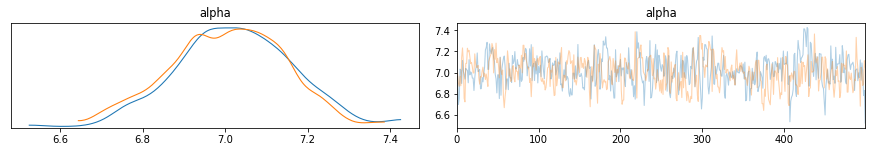

In [7]:
# The pm.traceplot function takes the trace object. You can add an additional argument
# called varnames to specify alpha, beta and sigma, the random variables you want to include in the plot.

pm.traceplot(trace,
            varnames = ['alpha'])
plt.show()

In each of the graphs we will find two curves given by different linestyle. Because we took two chains for
each parameter, for each chain the sampler generated the updated understanding of our distribution
trajectories.

In the left column of the traceplots, we can see the estimated posterior distribution for $\alpha$, which is
the intercept. From the density plot, we see that both curves appear to be bell-shaped, with more values
near the center and fewer as you move away on both sides. We can say the posterior distribution of alpha
follows approximately normal distribution. 

In addition, we can interpret the intercept that without TV advertisement, the expected product sales is
highly likely to fall between 6.8 and 7.2 thousands. 

The right column of plots shows the path of the simulated posterior value of $\alpha$ in each iteration. It
also uses different linetype to represent the corresponding MCMC chains. Since the chains maintain mostly
flat trajectories, the graphs indicates good convergence for the intercept $\alpha$.

/opt/conda/lib/python3.7/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
/opt/conda/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


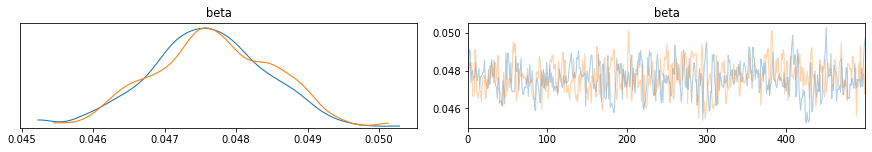

In [8]:
pm.traceplot(trace,
            varnames = ['beta'])
plt.show()

So by how much would TV advertisement boost the product sales in average? Here we look at the traceplot of
$\beta$, the regression coefficient. On the left, it is nice to see that both density curves of $\beta$
appear to be bell-shaped and mostly overlay each other. Again, it shows that $\beta$ follow approximately
normal distribution.

Since most sampled values fall between 0.046 and 0.049 for both curves, we can interpret the regression
coefficient that a unit increase of money spent on TV advertisement will highly likely to increase product sales
by between 0.046 and 0.049 thousand units. Similarly, both curves of $\beta$ converge well, as you can see the
trajectories are mostly flat.

/opt/conda/lib/python3.7/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
/opt/conda/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


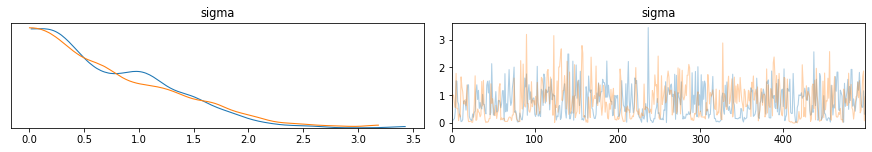

In [9]:
pm.traceplot(trace,
            varnames = ['sigma'])
plt.show()

We finally look at the behaviour of $\sigma$. Here is how we quantify the uncertainty based on probability.

We can see that the $\sigma$ value demonstrates a decreasing trend in probability as the value increases.
That is to say, the sampled values are highly likely to have very small standard deviation. Put it into the
context, it strongly suggests that the values of intercept and the effect of TV advertisement are precise. 

From the right, we can observe slight fluctuations appear at certain MCMC samples, but the overall
trajectories of $\sigma$ show decent convergence. 

### Summary Table

So is there a better way to know about the credible values for the expected product sales without
advertisement, and the effect of TV advertisement on the sales?

In [10]:
# We can use pm.summary to obtain a table-based summary statistics of the 
# posterior distributions for each parameter
# For clarity purposes, we round the results into 3 digits
pm.summary(trace).round(3)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,7.012,0.141,6.750,7.267,0.008,0.005,352.0,349.0,347.0,404.0,1.01
beta,0.048,0.001,0.046,0.049,0.000,0.000,410.0,410.0,405.0,289.0,1.01
sigma,0.767,0.591,0.000,1.785,0.033,0.023,327.0,327.0,261.0,292.0,1.00


This summary provides common posterior statistics such as posterior mean, posterior standard deviation,
highest posterior density referred as hpd, Markov Chain Standard Error statistic abbreviated as mcse, and
effective sample size as ess. Finally, you can see the convergence factor given by r_hat. The format of the
summary table is pandas.DataFrame.

See: https://docs.pymc.io/api/stats.html

For example, we see that the posterior mean of **alpha** is 7.01, with posterior standard deviation 0.14. 

Here we mainly focus on the hpd_3% and hpd_97% which calculate the highest posterior density on lower end
and higher end. These two values construct the 95% credible interval. We could say after observing the data,
we are 95% certain that 6.75 to 7.27 thousand products would be sold without advertisement. Similarly, we
could say after observing the data, we are 95% certain that increasing advertising expenditure by a thousand
through TV will boost product sales by 0.046 to 0.049 thousands. If you refer back to the traceplot, these
results confirm our observation of the density plots. 

If you look closely at the ess columns, ess_mean stands for the average effective sample size, which is an
evaluation metric for convergence. We won't go into the detail of ess at this point but I do encourage you
take a look about the concepts on the website.

Effective sample size: https://mc-stan.org/docs/2_18/reference-manual/effective-sample-size-section.html

### Gelman-Rubin Convergence Criterion

Finally, convergence is an essential factor evaluating the goodness of model. Here we look at the
Gelman-Rubin statistics which represent the ratio of the pooled variance of values across all chains to the
average variance of each chain. Gelman-Rubin statistics is scaled so that 1 indicates perfect convergence.
Theoretically, if the Gelman-Rubin statistic is less than 1.1, the chains are decently converged, so that no
additional model reconstruction is needed (Kang, 2018). 

In [2]:
# We can use pm.rhat function to obtain Gelman-Rubin statistics to check whether 
# the posterior distribution converges.
print(pm.rhat(trace,
                     varnames=['alpha', 'beta', 'sigma']))

NameError: name 'pm' is not defined

We can find the Gelman-Rubin statistics at "Data variables" part. Here all the Gelman-Rubin statistics are
approximately 1, indicating that all chains are converged.

Here are a few reference materials to help you, especially if you're interested in learning the probability
distributions under the hood, you can look at the following umich website. 
* http://www-personal.umd.umich.edu/~wiclarks/ASTRGroup/StatsSeminars/FlatWebpages/02_ProbabilityDistributions.html

If you're interested in statistics and want to know a glossary of probability distribution available 
to use in PyMC3, you can look at the documentation regarding PyMC3 distributions.

* https://docs.pymc.io/api/distributions/continuous.html

And here's a guideline for PyMC3 if you're so interested in understanding how you can construct Bayesian
models. 
* https://docs.pymc.io/notebooks/getting_started.html

Alright to recap, you have learned how to specify model, initiate sampling, compute and interpret posterior
diagnostics using PyMC3. In our code transfer test, you will apply some of these Bayesian methods to
iteratively update our knowledge regarding how accurate the NFL kickers can make the field goals. Good luck
with the rest of the study!